# Application: Stochastic Processes
In this notebook we put some of the techniques we just learned to good use. We will:
- write a function to simulate ARMA(p,q) processes
- write a function to simulate Markov-processes
- Introduce the Rouwenhorst method to approximate an AR(1) process using a Markov process on a finite grid.

Additionally, we write our own class `markov` with simulation and calibration methods.

## ARMA(p,q)

Recall the definition of an ARMA(p,q) process as 
$$ y_t = \alpha_0 + \sum_{j = 1}^p \alpha_j L^j y_t + \sum_{j = 1}^q \beta_j L^j \varepsilon_t + \varepsilon_t$$
where $L$ is the lag-operator and $\varepsilon_t\sim_{i.i.d.} \Phi(\sigma, 0)$ (we assume a normal distribution on the errors).

Let's write a function which takes in a dictionary holding $\alpha_0, \underline{\alpha}, \underline{\beta}$ and $\sigma$ to simulate the corresponding ARMA process.

In [ ]:
import numpy as np
from numba import prange, jit

In [ ]:
arma_dict = {
    'alpha_0': 0,
    'alpha': np.array([0.2, 0.4, 0.1]),
    'beta': np.array([0.1]),
    'sigma': 1
}

T = 1000

def sim_arma(arma_dict, T):
    p = len(arma_dict['alpha'])
    q = len(arma_dict['beta'])
    alpha = arma_dict['alpha']
    beta = arma_dict['beta']

    y = np.empty(1000+T) # 1000 burn-in draws
    eps = np.random.normal(0, arma_dict['sigma'], T+1000)
    y[0:max(p,q)] = eps[0:max(p,q)]  
    for i in np.arange(max(p,q)+1, T+1000):
        y[i] = np.vdot(y[i-(p+1):(i-1)], alpha) + np.vdot(eps[i-(q+1):(i-1)], beta)

    return y[-T:]


In [ ]:
arma_ts = sim_arma(arma_dict, 10_000)

Let's write a function to plot the time series.

In [ ]:
import matplotlib.pyplot as plt

def plot_time_series(time_series, arma_dict, xlabel='Time', ylabel='Value'):
    """
    Plots the given time series.

    Parameters:
    time_series (array-like): The time series data to plot.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    """
    title='Time Series ARMA(' + str(len(arma_dict['alpha'])) + ", " + str(len(arma_dict['beta'])) + ")"

    plt.figure(figsize=(10, 6))
    plt.plot(time_series, color='blue', linestyle='-', linewidth=1.)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()



In [ ]:
# Plot the time series
plot_time_series(arma_ts, arma_dict)

Recall now that a given $ARMA(p,q)$ is stationary if and only if all roots of the characteristic polynomial on the AR-part, 
$$ 1 - L^1 \alpha_1 - ... - L^q \alpha_q $$
are outside the (complex) unit circle. We write a function to check this. To do so, we use `roots(p)`, which return the roots of a polynomial with coefficients given in `p`.

In [ ]:
def is_stable(alpha):
    coefs = np.concatenate([[1], -alpha])[::-1] # [::-1] reverses an array
    print("The lag polynomial to check is:")
    print("1 -", " - ".join([f"{a}*L^{i}" for i, a in enumerate(alpha)]))
    print("The roots are:")
    roots = np.roots(coefs)
    for root in roots:
        print(f" {root:.2f}")

    # Check if all roots have modulus > 1
    are_roots_outside_unit_circle = all(np.abs(roots) > 1)
    if are_roots_outside_unit_circle : 
        print("\nThe process is stable.")
    else :
        print("\nThe process is unstable.")
    return are_roots_outside_unit_circle

Let's try it!

In [ ]:
is_stable(arma_dict['alpha'])

### A Taster of OOP

In Python, **classes** are a fundamental building block of object-oriented programming (OOP). A class is a blueprint for creating **objects** (instances), which can have **attributes** (variables) and **methods** (functions) associated with them.

**Basic Structure of a Class**

Here’s a simple example to demonstrate the structure of a class in Python:

In [ ]:
class Dog:
    # Class attribute (shared by all instances)
    species = "Canis familiaris"

    # The initializer method (also called the constructor)
    def __init__(self, name, age):
        # Instance attributes
        self.name = name
        self.age = age

    # Instance method
    def bark(self):
        return f"{self.name} says woof!"

    # Another instance method
    def get_human_years(self):
        return self.age * 7

# Creating instances (objects) of the class
dog1 = Dog("Buddy", 5)
dog2 = Dog("Lucy", 3)

# Accessing attributes and methods
print(dog1.name)  # Output: Buddy
print(dog1.bark())  # Output: Buddy says woof!
print(dog2.get_human_years())  # Output: 21



**Key Concepts:**

1. **Class Definition:**
   - A class is defined using the `class` keyword followed by the class name and a colon.
   - By convention, class names are written in CamelCase (e.g., `Dog`).

2. **Attributes:**
   - **Class Attributes:** These are shared across all instances of the class. In the example, `species` is a class attribute.
   - **Instance Attributes:** These are specific to each instance of the class. They are defined inside the `__init__` method (constructor). In the example, `name` and `age` are instance attributes.

3. **Methods:**
   - Methods are functions defined within a class that operate on instances of the class.
   - **Instance Methods:** These take `self` as the first parameter, which refers to the instance calling the method. For example, `bark` and `get_human_years` are instance methods in the `Dog` class.
   - The `__init__` method is a special method called automatically when a new instance of the class is created. It is used to initialize the instance's attributes.

4. **Creating Objects:**
   - Objects (instances) are created by calling the class as if it were a function, passing any arguments required by the `__init__` method.
   - For example, `dog1 = Dog("Buddy", 5)` creates an instance of the `Dog` class with `name` as `"Buddy"` and `age` as `5`.

5. **Accessing Attributes and Methods:**
   - Instance attributes and methods are accessed using dot notation (e.g., `dog1.name`, `dog1.bark()`).
   - Class attributes can be accessed directly via the class name or through any instance (e.g., `Dog.species` or `dog1.species`).


After we got the basic stuff out of the way, let's write a class for $ARMA(p, q)$ processes. We call the class `arma` and have the following desiderata:

- The class is initialized with the four inputs making up `arma_dict`
- It has a method allowing to simulate a the process with the process parameters
- we can update the process parameters whenever we like
- we can check whether the ARMA process is stable.

Let's get to it.

In [ ]:
class ARMA:

    def __init__(self, alpha_0, alpha, beta, sigma):
        self.alpha_0 = alpha_0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.arma_dict = {
            'alpha_0': self.alpha_0,
            'alpha': self.alpha,
            'beta': self.beta,
            'sigma': self.sigma
        }

    # Methods to update the parameters help in this class
    def set_alpha_0(self, alpha_0):
        self.alpha_0 = alpha_0
        self.arma_dict['alpha_0'] = alpha_0

    def set_alpha(self, alpha):
        self.alpha = alpha
        self.arma_dict['alpha'] = alpha

    def set_beta(self, beta):
        self.beta = beta
        self.arma_dict['beta'] = beta

    def set_sigma(self, sigma):
        self.sigma = sigma
        self.arma_dict['sigma'] = sigma

    # the simulation method
    def sim_arma(self, T):
        p = len(self.alpha)
        q = len(self.beta)
        alpha = self.alpha
        beta = self.beta

        y = np.empty(1000+T) # 1000 burn-in draws
        eps = np.random.normal(0, arma_dict['sigma'], T+1000)
        y[0:max(p,q)] = eps[0:max(p,q)]  
        for i in np.arange(max(p,q)+1, T+1000):
            y[i] = np.vdot(y[i-(p+1):(i-1)], alpha) + np.vdot(eps[i-(q+1):(i-1)], beta)

        return y[-T:]

    # checking for stability
    def is_stable(self):
        print(self.alpha)
        coefs = np.concatenate([[1], - self.alpha])[::-1] # [::-1] reverses an array
        print("-"*70)
        print("The lag polynomial to check is:")
        print("1 -", " - ".join([f"{a}*L^{i+1}" for i, a in enumerate(self.alpha)]))
        print("\nThe roots are:")
        roots = np.roots(coefs)
        for root in roots:
            print(f" {root:.2f}")

        # Check if all roots have modulus > 1
        are_roots_outside_unit_circle = all(np.abs(roots) > 1)
        if are_roots_outside_unit_circle : 
            print("\nThe process is stable.")
        else :
            print("\nThe process is unstable.")
        print("-"*70)
        return are_roots_outside_unit_circle

In [ ]:
# initialize myarma object
myarma = ARMA(0, np.array([0.3,0.3]), np.array([0.3]), 1)
# run and plot a little simulation
plot_time_series(myarma.sim_arma(1000), myarma.arma_dict)
myarma.is_stable()

# change the coefficient vector on AR-part 
myarma.set_alpha(np.array([3, 1]))
myarma.is_stable()


## Markov Processes

### Introduction to Discrete Markov Processes

A **Discrete Markov Process** (or **Markov Chain**) is a mathematical model describing a system that transitions between a finite or countable number of states in discrete time steps. The key feature of a Markov process is the **Markov Property**, which states that the future state depends only on the current state and not on the sequence of events that preceded it.

#### Key Definitions:

- **State Space ($S$)**: The set of all possible states the system can be in. It can be finite or countably infinite.

- **Time Parameter**: Discrete, often represented as $t = 0, 1, 2, \ldots$.

- **Transition Probability**:
  - Denoted as $P_{ij}$, it represents the probability of transitioning from state $i$ to state $j$ in one time step.
  - Mathematically: $P_{ij} = P(X_{t+1} = j \mid X_t = i)$, where $X_t$ is the state at time $t$.
  - Collect these in a matrix, $\Pi$
  - The sum of probabilities in each row equals 1: $\sum_{j} P_{ij} = 1$ for all $i$.

- **Initial Distribution ($\pi^{(0)}$)**:
  - A probability distribution over the state space at time $t = 0$.

- **n-Step Transition Probability**:
  - The probability of transitioning from state $i$ to state $j$ in $n$ steps, denoted as $P_{ij}^{(n)}$.
  - Calculated by raising the transition matrix to the $n^{th}$ power: $(P^{(n)})' = (P')^n$.

- **Stationary Distribution ($\pi$)**:
  - A probability distribution over states that remains unchanged as the process evolves.
  - Satisfies $\pi = \pi P$.
  - Represents the long-term behavior of the Markov process if it exists and is unique.

Given a distribution $\pi_t$, the next period distribution will be $\pi_{t+1} = \Pi' \pi_t$

In [200]:
# transition matrix
Pi = np.array([
    [0.2, 0.4, 0.4],
    [0.1, 0.5, 0.4],
    [0.8, 0.1, 0.1]
])

# current distribution
pi = np.array([0.5, 0.5, 0])

# next period distribution
pi @ Pi

array([0.15, 0.45, 0.4 ])

**Exercise:** Write a function that checks whether a given matrix is a Markov matrix.

Then, write a function which takes a Markov transition matrix and calculates the stationary distribution. (Hint: $\Pi^N$ converges to a matrix which contains the stationary distribution(s) in its rows.) 

In [201]:
# TBD

M = Pi
for i in range(50):
    M = Pi @ M
M

array([[0.35042735, 0.34188034, 0.30769231],
       [0.35042735, 0.34188034, 0.30769231],
       [0.35042735, 0.34188034, 0.30769231]])

## Rouwenhorst Method to Approximate an AR(1) Process with a Markov Chain

### Advantages of the Rouwenhorst Method:

- **Flexibility:** The Rouwenhorst method is particularly useful for approximating AR(1) processes with high persistence (i.e., when $ \rho $ is close to 1) because it can accommodate the high persistence and the correct distribution properties of the AR(1) process.
- **Accuracy:** It provides a good approximation with relatively few states (even with a small $ n $), making it computationally efficient.

---

For an arbitrary Markov process mapping to income states and corresponding income levels $ y $, consider the simplest case:

$$
\begin{align*}
\log y_t &= \rho \log y_{t-1} + \epsilon_t, \quad \epsilon_t \sim N(0, \alpha^2), \\
\alpha^2 &= \mathrm{Var}(\log y_t) (1 - \rho^2).
\end{align*}
$$

- Note that $\mathrm{Var}(\log y_t)$ is the long-run variance as well as the cross sectional variance, which is typically directly estimated. So is $\rho$, and we infer $\alpha$.  

- Our goal is to approximate this continuous AR(1) process with $ n $ discrete states using the **Rouwenhorst Method**. This method helps us construct a Markov transition matrix $\Pi$ that closely matches the properties of the AR(1) process.

- To approximate the AR(1) process, we represent it with $ n $ discrete states. Each state is a sum $ e_t \in \{0,1,..., n-1\} $ of $ n-1 $ underlying hidden binary state variables. Each binary state has a probability $ p $ of staying at its current value and a probability $ 1-p $ of switching to a different value.

- The parameter $ p $ is set to match the persistence of the AR(1) process, where $ p = \frac{1+\rho}{2} $. The standard deviation of the underlying state $ e_t $ is given by $ \frac{\sqrt{n-1}}{2} $. To match the cross-sectional standard deviation of log income, we scale (the grid of) $ e_t $ by $ \frac{\alpha}{\sqrt{1 - \rho^2}} \frac{2}{\sqrt{n-1}} = \sigma_y \frac{2}{\sqrt{n-1}}  $.

- Finally, the goal is to find the discretized income process corresponding to these states.

The Markov transition matrix $\Pi^n$ for the states $ e $ follows the recursion:

$$
\tilde{\Pi}^{n} = p \begin{bmatrix} \Pi^{n-1} & \mathbf{0} \\ \mathbf{0}' & 0 \end{bmatrix} 
+ (1-p) \begin{bmatrix} \mathbf{0} & \Pi^{n-1} \\ 0 & \mathbf{0} \end{bmatrix} 
+ (1-p) \begin{bmatrix} \mathbf{0}' & 0 \\ \Pi^{n-1} & \mathbf{0} \end{bmatrix} 
+ p \begin{bmatrix} 0 & \mathbf{0}' \\ \mathbf{0} & \Pi^{n-1} \end{bmatrix} 
\tag{6}
$$

The final transition matrix $\Pi^n$ is equal to $\tilde{\Pi}^{n}$ for the first and last rows, and $\tilde{\Pi}^{n}/2$ for all other rows. The base case for the recursion is:

$$
\Pi^{2} = \begin{bmatrix} p & 1-p \\ 1-p & p \end{bmatrix}
$$

This procedure can be implemented in a function ```rouwenhorst(n, rho, sd_log_y)``` which returns a transition matrix and a grid for $\log y$.

Let's get to it:

In [338]:
# sigma is the sd of the error, e_t
@jit(nopython=T)
def rouwenhorst(n, rho, sd_log_y):
    
    # the grid    
    e = np.arange(n) # sd of e on this grid with Pi is sqrt(n-1)/2
    e = e / ( (n-1)**0.5 /2 ) # now its unit sd
    e = e * sd_log_y # now it's the sd of the cross section of log_y

    # the transition matrix
    p = (1+rho)/2
    Pi = np.array([[p, 1-p], [1-p, p]])
    
    while Pi.shape[0] < n:
        Pi_next = np.zeros((1+Pi.shape[0], 1+Pi.shape[1]))
        Pi_next[0:Pi.shape[0], 0:Pi.shape[1]] += Pi * p
        Pi_next[0:Pi.shape[0], -Pi.shape[1]:] += Pi * (1-p)
        Pi_next[-Pi.shape[0]:, -Pi.shape[1]:] += Pi * p
        Pi_next[-Pi.shape[0]:, 0:Pi.shape[1]] += Pi * (1-p)
        Pi_next[1:-1, :] /= 2
        Pi = Pi_next

    return Pi, e

@jit(nopython=True)
def stationary_dist(Pi):
    Pi_stationary = Pi.copy()
    eps = 1
    while eps > 10E-12:
        Pi_old = Pi_stationary.copy()
        Pi_stationary = Pi_stationary @ Pi_stationary
        eps = np.max(np.abs(Pi_stationary - Pi_old))

    if np.max(
            np.abs( 
                np.sum(Pi_stationary - Pi_stationary,axis = 0) / Pi_stationary.shape[0]
            )
        ) < 10E-10: # the ugly sum.../ .shape construction is because numpy cant handle np.mean with axis args
        print("the steady state is unique.")

    return Pi_stationary

def normalize_log_y(log_y, pi_ss): # make log_y have unit mean
    log_y_norm = log_y / np.vdot(log_y, pi_ss)
    return log_y_norm

the steady state is unique.


the steady state is unique.


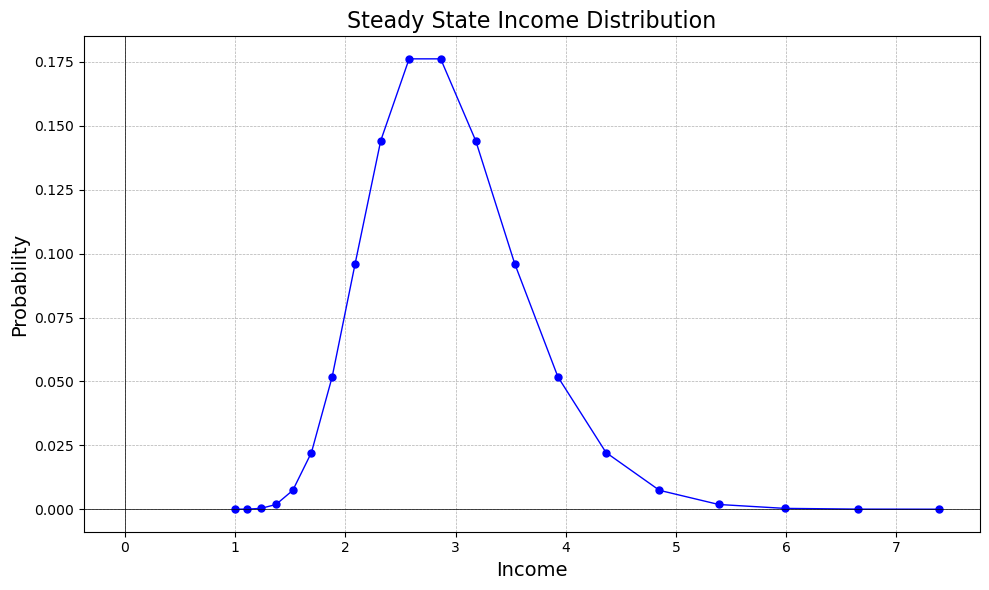

In [345]:
# lets test our code
Pi, log_y = rouwenhorst(20, 0.975, 0.7)
pi_ss = stationary_dist(Pi)[0,:]
y_grid = np.exp(normalize_log_y(log_y, pi_ss))

# plot income and probability distribution
plt.figure(figsize=(10, 6))
plt.plot(y_grid, pi_ss, marker='o', linestyle='-', color='b', markersize=5, linewidth=1)
plt.title('Steady State Income Distribution', fontsize=16)
plt.xlabel('Income', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.tight_layout()
plt.show()


Finally, we can put these functions together to write a "rouwenhorst" module.